In [2]:
import tensorflow as tf
if(tf.__version__ != "2.0.0-beta1"):
  !pip install --upgrade tensorflow-gpu==2.0.0b1
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())

     |████████████████████████████████| 348.9MB 76kB/s 
     |████████████████████████████████| 3.1MB 34.9MB/s 
     |████████████████████████████████| 501kB 37.1MB/s 


1.14.0
True


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import random

keras = tf.keras

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

local_directory = "/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia"
os.chdir(local_directory)
!pwd & ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia
 chest_xray
 chest_xray_dataset
'Copy of ResNet.ipynb'
 Data_exploration.ipynb
 main.ipynb
 Prepare_Kaggle.ipynb
 ResNet.ipynb
 resnet_train_cache.tf-data_0.data-00000-of-00001.tempstate476731692081975760
 resnet_train_cache.tf-data_0.lockfile
 resnet_val_cache.tf-data_0.data-00000-of-00001.tempstate8465232386454851418
 resnet_val_cache.tf-data_0.lockfile


In [5]:
!ls chest_xray/

test  train  val


In [0]:
# !cp chest_xray/train/PNEUMONIA/* chest_xray/test/PNEUMONIA/* chest_xray/val/PNEUMONIA/*  chest_xray_dataset/PNEUMONIA/

In [0]:
# !cp chest_xray/train/NORMAL/* chest_xray/test/NORMAL/* chest_xray/val/NORMAL/*  chest_xray_dataset/NORMAL/

In [0]:
# !ls chest_xray/train/PNEUMONIA -1 | wc -l
# !ls chest_xray/train/NORMAL -1 | wc -l

In [10]:
!ls chest_xray_dataset/PNEUMONIA/ -1 | wc -l
!ls chest_xray_dataset/NORMAL/ -1 | wc -l

1583


In [0]:
IMG_SIZE = 256 # All images will be resized to this size
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 124
num_train, num_val, num_test = 5216, 16, 624
count = 16

DATA_ROOT = local_directory + "/chest_xray"
DATA_ROOT = pathlib.Path(DATA_ROOT)

TRAIN_LOC = pathlib.Path(str(DATA_ROOT) + '/train')
VAL_LOC = pathlib.Path(str(DATA_ROOT) + '/val')
TEST_LOC = pathlib.Path(str(DATA_ROOT) + '/test')

train_image_paths = list(TRAIN_LOC.glob('*/*.jpeg'))
train_image_paths = [str(path) for path in train_image_paths]
random.shuffle(train_image_paths)

val_image_paths = list(VAL_LOC.glob('*/*.jpeg'))
val_image_paths = [str(path) for path in val_image_paths]
random.shuffle(val_image_paths)

test_image_paths = list(TEST_LOC.glob('*/*.jpeg'))
test_image_paths = [str(path) for path in test_image_paths]
random.shuffle(test_image_paths)


label_names = sorted(item.name for item in TRAIN_LOC.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index, name in enumerate(label_names))

train_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in train_image_paths]

val_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in val_image_paths]

test_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in test_image_paths]

image_count = len(train_image_labels)

# for item in TRAIN_LOC.iterdir():
#   print(item)

# print("First 10 train labels: ", train_image_labels[:10])

# for label in zip(val_image_paths, val_image_labels):
#   print(label)
  
print("Trained Images: %d,\nValidation Images: %d, \nTest Images: %d." % 
      (len(train_image_labels), len(val_image_labels), len(test_image_labels)))


Trained Images: 5216,
Validation Images: 16, 
Test Images: 624.


In [0]:
val_image_paths

['/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg',
 '/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg',
 '/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg',
 '/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg',
 '/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg',
 '/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg',
 '/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg',
 '/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg'

In [0]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = image/127.5 -1 # normalize to [-1,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

def show_patient(img, label):
  img = img.numpy()
  print(img.shape)
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
  fig.suptitle(label_names[label].title(), fontsize=24)
#   plt.subplots_adjust(hspace=0.1, top=0.1, bottom=0.05)
  for i, ax in enumerate(axs.flat):
      ax.imshow(img[...,i], "gray")
  plt.show()
    
# test_path = '/content/drive/My Drive/chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0117-0001.jpeg'
# label = 0

# # plt.imshow(load_and_preprocess_image(test_path))
# # plt.grid(False)
# # plt.xlabel("TEST")
# # plt.title(label_names[label].title())
# # print()

# img = load_and_preprocess_image(test_path)
# show_patient(img, label)



In [0]:
""" Building a dataset """


ds_train = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_labels))
train_ds = ds_train.map(load_and_preprocess_from_path_label)

ds_val = tf.data.Dataset.from_tensor_slices((val_image_paths, val_image_labels))
val_ds = ds_val.map(load_and_preprocess_from_path_label)

ds_test = tf.data.Dataset.from_tensor_slices((test_image_paths, test_image_labels))
test_ds = ds_test.map(load_and_preprocess_from_path_label)

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
training_batches = train_ds.cache() # filename='./resnet_train_cache.tf-data'
training_batches = training_batches.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=500, count=count))
training_batches = training_batches.batch(BATCH_SIZE).prefetch(1)

validation_batches = val_ds.cache() # filename='./resnet_val_cache.tf-data'
validation_batches = validation_batches.batch(BATCH_SIZE).prefetch(1)

test_batches = test_ds.cache() # filename='./resnet_test_cache.tf-data'
test_batches = test_batches.batch(BATCH_SIZE).prefetch(1)

# for i, val in enumerate(test_batches):
#   print(i, val[0].numpy().shape, val[1].numpy())

W0710 16:27:21.329204 140131050985344 deprecation.py:323] From <ipython-input-6-f47b875796ff>:17: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


In [0]:
for i,j in training_batches.take(5):
  print(j)
  break

tf.Tensor(
[1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1
 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(124,), dtype=int32)


In [0]:
baseModel = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=IMG_SHAPE, pooling=None) # , classes=2)


In [0]:
baseModel.trainable = False
no_of_layers=0
for layer in baseModel.layers:
  no_of_layers+=1
  
print(no_of_layers)

311


In [0]:
len(baseModel.layers)

311

In [0]:
baseModel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [0]:
#feature_batch = baseModel(image_batch) # This feature extractor converts each 265x265x3 image to a 5x5x1280 block of features.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

#Add prediction head
prediction_layer = keras.layers.Dense(2) # len(label_names =1)
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)


In [0]:
model = tf.keras.Sequential([
  baseModel,
  global_average_layer,
  prediction_layer
])


base_learning_rate = 0.00001
model.compile(optimizer=tf.optimizers.Adam(),#tf.keras.optimizers.SGD(lr=base_learning_rate),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 2


In [0]:
# num_train, num_val, num_test = 5216, 16, 624

validation_steps = 7
no_epochs = 30


steps_per_epoch=tf.math.ceil(len(train_image_paths)/BATCH_SIZE).numpy()

print("Steps per epoch: ", steps_per_epoch)

loss0,accuracy0 = model.evaluate(test_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
# print("initial mse: {:.2f}".format(mse0))


Steps per epoch:  43.0
6/7 [========================>.....] - ETA: 2s - loss: 5.4540 - accuracy: 0.4062

W0710 16:27:56.721305 140131050985344 training_generator.py:235] Your dataset ran out of data; interrupting training. Make sure that your dataset can generate at least `steps * epochs` batches (in this case, 7 batches). You may need to use the repeat() function when building your dataset.


initial loss: 4.67
initial accuracy: 0.41


In [0]:
history = model.fit(training_batches,
                    epochs=no_epochs,
                    validation_data=test_batches,
                    validation_steps= validation_steps,
                   steps_per_epoch=steps_per_epoch)
# model.fit(ds, epochs=1, steps_per_epoch=3)

Epoch 1/30


W0710 16:28:03.278371 140131050985344 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


42/43 [============================>.] - ETA: 1s - loss: 2.6144 - accuracy: 0.7167

W0710 16:29:06.839462 140131050985344 training_generator.py:235] Your dataset ran out of data; interrupting training. Make sure that your dataset can generate at least `validation_steps * epochs` batches (in this case, 7 batches). You may need to use the repeat() function when building your dataset.


43/43 [==============================] - 70s 2s/step - loss: 2.6084 - accuracy: 0.7176 - val_loss: 3.8351 - val_accuracy: 0.5737


In [0]:
model.evaluate(test_batches, steps = validation_steps)

5/7 [====================>.........] - ETA: 2s - loss: 4.5777 - accuracy: 0.5734

W0710 16:29:13.727953 140131050985344 training_generator.py:235] Your dataset ran out of data; interrupting training. Make sure that your dataset can generate at least `steps * epochs` batches (in this case, 7 batches). You may need to use the repeat() function when building your dataset.


[3.8351378781454906, 0.57371795]

In [0]:
print(history.params)


{'batch_size': None, 'epochs': 30, 'steps': 43.0, 'samples': 43.0, 'verbose': 0, 'do_validation': True, 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}


Text(0.5, 0, 'epoch')

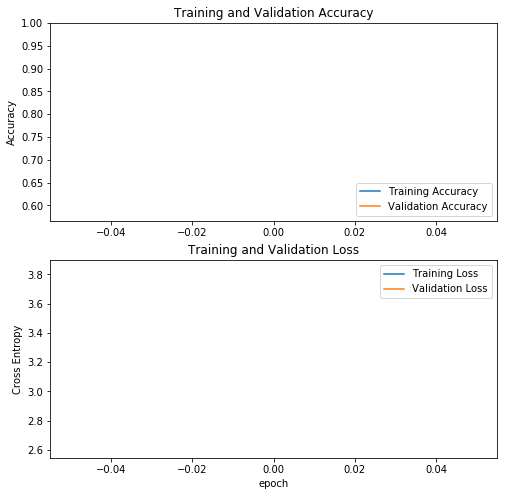

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

In [0]:
baseModel.trainable = True

fine_tune_at = 250

# Freeze all the layers before the `fine_tune_at` layer
for layer in baseModel.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.SGD(lr=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 10,545,538
Non-trainable params: 11,261,344
_________________________________________________________________


In [0]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 37


In [0]:
fine_tune_epochs = 5
no_epochs = 50 # steps_per_epoch
total_epochs =  no_epochs + fine_tune_epochs

history_fine = model.fit(training_batches,
                         epochs=total_epochs,
                         initial_epoch = no_epochs,
#                          validation_data=validation_batches
                        )


Epoch 51/55
674/674 [==============================] - 366s 543ms/step - loss: 2.2568 - accuracy: 0.7765
Epoch 52/55
674/674 [==============================] - 346s 513ms/step - loss: 2.2468 - accuracy: 0.7800
Epoch 53/55
674/674 [==============================] - 347s 514ms/step - loss: 2.2391 - accuracy: 0.7824
Epoch 54/55
674/674 [==============================] - 345s 511ms/step - loss: 2.2342 - accuracy: 0.7846
Epoch 55/55
674/674 [==============================] - 345s 512ms/step - loss: 2.2290 - accuracy: 0.7854


In [0]:
model.evaluate(test_batches, steps = validation_steps)

6/7 [========================>.....] - ETA: 1s - loss: 5.2667 - accuracy: 0.6218

W0710 16:58:33.884740 140131050985344 training_generator.py:235] Your dataset ran out of data; interrupting training. Make sure that your dataset can generate at least `steps * epochs` batches (in this case, 7 batches). You may need to use the repeat() function when building your dataset.


[4.514298030308315, 0.6217949]

In [0]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

KeyError: ignored